# **Project 02. Financial Spending Category Classification**

### **1. Import Dependencies & Load dataset**

In [ ]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import pandas as pd
import numpy as np
import random
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

W1201 03:29:56.473000 3776 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
df = pd.read_excel('ubvelox.xlsx')
df

,Category,Text
0,취미/여가,POP PC방
1,주거/통신,SKT
2,용돈/생활비,비상금 유지
3,주거/통신,인천가스
4,교통,전국고속버스운송사업
...,...,...
3788,기부/후원,희망조약돌
3789,취미/여가,희야골프채
3790,병원/건강,희야병원비
3791,병원/건강,힐링약국


### **EDA**

In [3]:
# Changing Category names to English for Visualization

print(len(df['Category'].unique()))
df['Category'].unique()

25


array(['취미/여가', '주거/통신', '용돈/생활비', '교통', '카드대금', '보험', '마트/편의점', '병원/건강',
       '자동차', '대출', '교육', '여행/숙박', '생활편의', '카페/간식', '구독', '쇼핑', '경조/선물',
       '저축/투자', '세금', '외식', '미용', '모임', '자녀', '기부/후원', '반려동물'],
      dtype=object)

In [4]:
print(len(df['Category'].unique()), ' Original Category')
print(df['Category'].unique())

column_list = ['Leisure', 'Telecom', 'Allowance', 'Transportation', 'Card', 'Insurance', 'Supermarket', 'Health', 
               'Car', 'Loans', 'Education', 'Travel', 'Amenity', 'Cafe', 'Subscription','Shopping', 'Gift',
               'Savings', 'Tax', 'Restaurant', 'Beauty', 'Association', 'Children', 'Donation', 'Pet'
               ]
print(len(column_list))

mapping = dict(zip(df['Category'].unique(), column_list))

df['Category_Eng'] = df['Category'].map(mapping)
df = df[['Category_Eng', 'Text']]
df

25  Original Category
['취미/여가' '주거/통신' '용돈/생활비' '교통' '카드대금' '보험' '마트/편의점' '병원/건강' '자동차' '대출'
 '교육' '여행/숙박' '생활편의' '카페/간식' '구독' '쇼핑' '경조/선물' '저축/투자' '세금' '외식' '미용' '모임'
 '자녀' '기부/후원' '반려동물']
25


,Category_Eng,Text
0,Leisure,POP PC방
1,Telecom,SKT
2,Allowance,비상금 유지
3,Telecom,인천가스
4,Transportation,전국고속버스운송사업
...,...,...
3788,Donation,희망조약돌
3789,Leisure,희야골프채
3790,Health,희야병원비
3791,Health,힐링약국


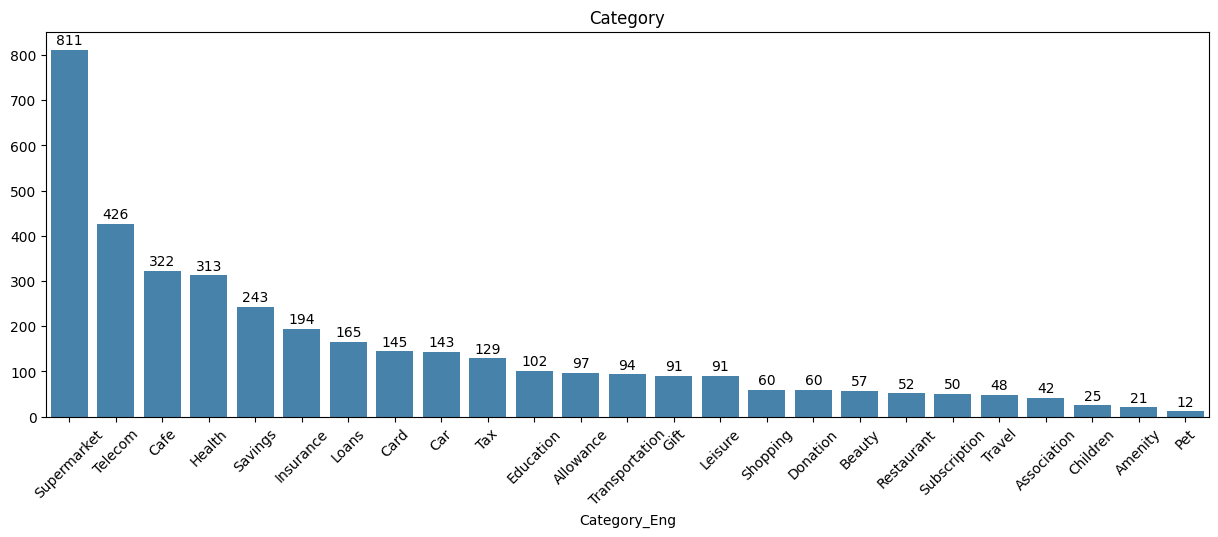

In [5]:
x=df['Category_Eng'].value_counts()

plt.figure(figsize=(15,5))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.9)
plt.title("Category")

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

Max length of data : 21
Average length of data : 6.523596098075402


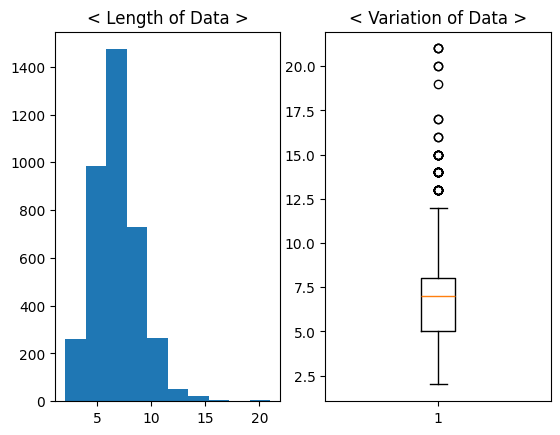

In [7]:
data_length = [len(data) for data in df['Text']]
 
print('Max length of data :', np.max(data_length))
print('Average length of data :', np.mean(data_length))

plt.subplot(1,2,1)
plt.hist(data_length, bins=10)
plt.title("< Length of Data >")
plt.subplot(1,2,2)
plt.boxplot(data_length)
plt.title("< Variation of Data >")

plt.show()

In [8]:
le = LabelEncoder()
labels = le.fit_transform(df['Category_Eng'])
df['labels'] = labels

NUM_LABELS = len(le.classes_)
print("Classes:", le.classes_)
print("NUM_LABELS:", NUM_LABELS)

Classes: ['Allowance' 'Amenity' 'Association' 'Beauty' 'Cafe' 'Car' 'Card'
 'Children' 'Donation' 'Education' 'Gift' 'Health' 'Insurance' 'Leisure'
 'Loans' 'Pet' 'Restaurant' 'Savings' 'Shopping' 'Subscription'
 'Supermarket' 'Tax' 'Telecom' 'Transportation' 'Travel']
NUM_LABELS: 25


In [10]:
df = df[['Text', 'labels']]
df.tail()

,Text,labels
3788,희망조약돌,8
3789,희야골프채,13
3790,희야병원비,11
3791,힐링약국,11
3792,힘찬약국,11


In [11]:
df.drop_duplicates(subset = ['Text'], inplace=True)
df['Text'] = df['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['Text'].replace('', np.nan, inplace=True)
df = df.dropna(how='any')
print('Size of Data :',len(df))

Size of Data : 3424


C:\Users\Leopolt\AppData\Local\Temp\ipykernel_3776\1174092575.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Text'].replace('', np.nan, inplace=True)


### **2. Data split & Preprocessing**

In [13]:
train, test = train_test_split(df, random_state=42,test_size=0.3)

print(len(train), 'train examples')
print(len(test), 'test examples')

2396 train examples
1028 test examples


In [14]:
print(train['labels'].value_counts())
print(test['labels'].value_counts())

labels
20    557
4     228
11    209
22    202
17    128
12    113
5     105
14    104
6      75
9      74
23     64
0      64
10     62
21     60
13     57
18     44
16     42
3      40
24     36
19     35
8      32
2      29
7      15
1      14
15      7
Name: count, dtype: int64
labels
20    251
11    103
4      94
22     76
17     64
12     60
14     41
5      38
13     33
21     30
6      28
23     25
10     22
8      21
0      21
9      20
3      16
18     16
19     15
2      11
24     11
16     10
7      10
1       7
15      5
Name: count, dtype: int64


In [16]:
# Preprocessing

document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train['Text']]
document_bert[:5]

# Tokenizing

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]
print(tokenized_texts[0])

# Padding

MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

print('input_ids의 길이 : ',len(input_ids))

['[CLS]', '차', '##량', '##유', '##지', '##비', '[SEP]']
input_ids의 길이 :  2396


In [17]:
# Attention mask
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


#### **Train - validation split**

In [18]:
# train - validation split

train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids,  train['labels'].values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=42,
                                                       test_size=0.1)

In [19]:
# pytorch tensor

train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels      = torch.tensor(train_labels,      dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)


# BATCH_SIZE
# Fit to GPU's VRAM

BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

print('Size of train_data : ',len(train_data))
print('Size of validation_data : ',len(validation_data))
print('Size of train_dataloader : ',len(train_dataloader))
print('Size of validation_dataloader : ',len(validation_dataloader))

Size of train_data :  2156
Size of validation_data :  240
Size of train_dataloader :  68
Size of validation_dataloader :  8


#### **Test data**

In [20]:
# Test data preprocessing

sentences = test['Text']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = test['labels'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
#test_labels = torch.tensor(labels)
test_labels       = torch.tensor(labels,            dtype=torch.long)



test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [21]:
device = torch.device("cuda")
device

device(type='cuda')

### **3. Build Model**

In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=NUM_LABELS)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [23]:
# learning Scheduling

# optimizer
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=2e-5, eps=1e-6)
#optimizer = AdamW(model.parameters(), lr = 2e-5,  eps = 1e-8 )

# epochs
epochs = 10

# training steps
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [24]:
# accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# time
def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
time0 = time.time()
print(time.strftime('%c', time.localtime(time.time())))

# Random seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Initialize gradient
model.zero_grad()


for epoch_i in range(0, epochs):

    # Training data

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()


    total_loss = 0

    model.train()

    
    
    for step, batch in enumerate(train_dataloader):
        
        if step % 500 == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step:>5,} of {len(train_dataloader):>5,}.    Elapsed: {elapsed}.')
            
        b_input_ids  = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels     = batch[2].to(device)
        
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
    
    
        loss = outputs[0]


        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Validation data

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits_cpu = logits.detach().cpu().numpy()
        pred_flat_M = np.argmax(logits_cpu, axis=1).flatten()
        
        logits = logits_cpu
        label_ids = b_labels.detach().cpu().numpy()


        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


print("")
print("Training complete!")

print("Test took: {:}".format(format_time(time.time() - time0)))

Mon Dec  1 03:50:56 2025

======== Epoch 1 / 10 ========
Training...

  Average training loss: 2.55
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.52
  Validation took: 0:00:01

======== Epoch 2 / 10 ========
Training...

  Average training loss: 1.67
  Training epcoh took: 0:00:20

Running Validation...
  Accuracy: 0.71
  Validation took: 0:00:01

======== Epoch 3 / 10 ========
Training...

  Average training loss: 1.18
  Training epcoh took: 0:00:20

Running Validation...
  Accuracy: 0.79
  Validation took: 0:00:01

======== Epoch 4 / 10 ========
Training...

  Average training loss: 0.83
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:01

======== Epoch 5 / 10 ========
Training...

  Average training loss: 0.61
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:01

======== Epoch 6 / 10 ========
Training...

  Average training loss: 0.47
  Training epcoh took: 0:00:21

Run

### **4. Metrics (Confusion Matrix)**

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

time1 = time.time()
print(time.strftime('%c', time.localtime(time.time())))

# Test metrics
print(time.strftime('%c', time.localtime(time.time())))
pred_collection = np.array([])
label_collection = np.array([])

t0 = time.time()

model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(test_dataloader):

    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)


    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat_M = np.argmax(logits, axis=1).flatten()
    labels_flat_M = label_ids.flatten()

    pred_collection = np.concatenate((pred_collection, pred_flat_M))
    label_collection = np.concatenate((label_collection, labels_flat_M))


    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1


print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

print("pred_collection : ",len(pred_collection))
print("label_collection : ",len(label_collection))
print(confusion_matrix(pred_collection, label_collection))
print(classification_report(pred_collection, label_collection))

print("Time took: {:}".format(format_time(time.time() - time1)))

Mon Dec  1 03:54:30 2025
Mon Dec  1 03:54:30 2025

Accuracy: 0.88
Test took: 0:00:03
pred_collection :  1028
label_collection :  1028
[[ 19   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0]
 [  0   1   6   0   0   0   0   0   2   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0]
 [  0   2   0  13   0   0   0   0   1   0   0   0   2   0   1   0   0   0
    0   0   1   0   0   0   0]
 [  0   0   0   1  86   0   0   0   0   0   0   1   0   1   0   0   1   0
    0   0   0   0   1   0   0]
 [  0   0   0   0   0  34   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  27   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   1   0   0   0 

c:\Users\Leopolt\Desktop\_Python\_env\ML_kim\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Leopolt\Desktop\_Python\_env\ML_kim\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Leopolt\Desktop\_Python\_env\ML_kim\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

### **5. ROC Curve**

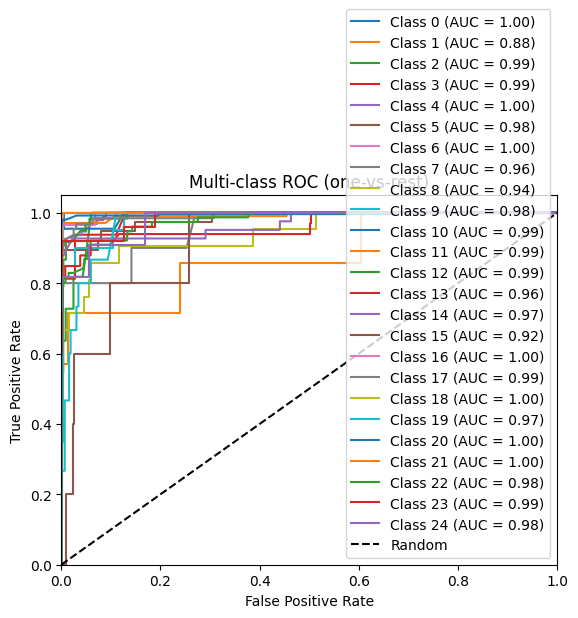

In [28]:
# Multi-class ROC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

num_classes = 25

model.eval()

all_labels = []
all_logits = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids  = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels     = batch[2].to(device)

        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )

        logits = outputs[0]

        all_logits.append(logits.detach().cpu().numpy())
        all_labels.append(b_labels.detach().cpu().numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Binarize labels for one-vs-rest ROC
y_bin = label_binarize(all_labels, classes=np.arange(num_classes))

# Probabilities
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

# Plot one ROC per class
plt.figure()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC (one-vs-rest)")
plt.legend(loc="lower right")
plt.show()